# Mod 3: Project 2

### UFO Sightings

#### Import the following libraries

In [115]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import ttest_ind, chisquare
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Connect to the database called ufos.db which has two tables called populations and ufos. 

In [42]:
conn = sqlite3.connect('ufos.db')

In [43]:
c = conn.cursor()

#### Grab all the data from the database populations and save it as a dataframe table. 

In [44]:
c.execute('''select * from populations''')
population_df = pd.DataFrame(c.fetchall())
population_df.columns = [i[0] for i in c.description]

In [45]:
population_df.head()

,Geographic Area,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AL,"4,785,448","4,798,834","4,815,564","4,830,460","4,842,481","4,853,160","4,864,745","4,875,120","4,887,871"
1,AK,"713,906","722,038","730,399","737,045","736,307","737,547","741,504","739,786","737,438"
2,AZ,"6,407,774","6,473,497","6,556,629","6,634,999","6,733,840","6,833,596","6,945,452","7,048,876","7,171,646"
3,AR,"2,921,978","2,940,407","2,952,109","2,959,549","2,967,726","2,978,407","2,990,410","3,002,997","3,013,825"
4,CA,"37,320,903","37,641,823","37,960,782","38,280,824","38,625,139","38,953,142","39,209,127","39,399,349","39,557,045"


#### Removed all the commas from the population values. 

In [46]:
column_names = population_df.columns

for column_name in column_names:
    population_df[column_name]=population_df[column_name].apply(lambda x: x.replace(',',''))
population_df.head()


,Geographic Area,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AL,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,AK,713906,722038,730399,737045,736307,737547,741504,739786,737438
2,AZ,6407774,6473497,6556629,6634999,6733840,6833596,6945452,7048876,7171646
3,AR,2921978,2940407,2952109,2959549,2967726,2978407,2990410,3002997,3013825
4,CA,37320903,37641823,37960782,38280824,38625139,38953142,39209127,39399349,39557045


#### Changed the population values from objects to integers. 

In [47]:
for column_name in column_names[1:]:
    population_df[column_name] = population_df[column_name].astype(int)
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
Geographic Area    51 non-null object
2010               51 non-null int64
2011               51 non-null int64
2012               51 non-null int64
2013               51 non-null int64
2014               51 non-null int64
2015               51 non-null int64
2016               51 non-null int64
2017               51 non-null int64
2018               51 non-null int64
dtypes: int64(9), object(1)
memory usage: 4.1+ KB


#### Grabbing the data from the ufos table and making it a dataframe. 

In [48]:
c.execute('''select * from ufos''')
ufo_df = pd.DataFrame(c.fetchall())
ufo_df.columns = [i[0] for i in c.description]
ufo_df.head()

,Date_Time,City,State,Shape,Duration,Summary,Date_Posted,Duration_sec,event_date
0,5/9/19 21:15,Cincinnati,OH,Triangle,15 seconds,Large V/triangle-shaped craft that moved silen...,5/9/19,15.0,2019-05-09 21:15:00
1,5/8/19 23:00,Statesboro,GA,Triangle,20 seconds,"Two UFO's near Statesboro, Ga. 11:00 PM 5-9-2019.",5/9/19,20.0,2019-05-08 23:00:00
2,5/8/19 23:00,Norfolk,VA,Light,>10 minutes,"Extremely loud bang, light spotted in sky.",5/9/19,600.0,2019-05-08 23:00:00
3,5/8/19 01:30,Saint George,UT,Other,1:30,Started noticing a huge flash of light @ aroun...,5/9/19,90.0,2019-05-08 01:30:00
4,5/8/19 01:00,Highlands,NC,Light,1 minute,I have about 10 recordings from last night on ...,5/9/19,60.0,2019-05-08 01:00:00


In [49]:
ufo_df.head()

,Date_Time,City,State,Shape,Duration,Summary,Date_Posted,Duration_sec,event_date
0,5/9/19 21:15,Cincinnati,OH,Triangle,15 seconds,Large V/triangle-shaped craft that moved silen...,5/9/19,15.0,2019-05-09 21:15:00
1,5/8/19 23:00,Statesboro,GA,Triangle,20 seconds,"Two UFO's near Statesboro, Ga. 11:00 PM 5-9-2019.",5/9/19,20.0,2019-05-08 23:00:00
2,5/8/19 23:00,Norfolk,VA,Light,>10 minutes,"Extremely loud bang, light spotted in sky.",5/9/19,600.0,2019-05-08 23:00:00
3,5/8/19 01:30,Saint George,UT,Other,1:30,Started noticing a huge flash of light @ aroun...,5/9/19,90.0,2019-05-08 01:30:00
4,5/8/19 01:00,Highlands,NC,Light,1 minute,I have about 10 recordings from last night on ...,5/9/19,60.0,2019-05-08 01:00:00


#### The total number of sightings.

In [50]:
len(ufo_df)

87749

#### Converted Duration_sec values into floats from strings and then divided by 60 to convert seconds to minutes.

In [51]:
ufo_df.Duration_sec=ufo_df.Duration_sec.astype(float)/60
ufo_df.head()

,Date_Time,City,State,Shape,Duration,Summary,Date_Posted,Duration_sec,event_date
0,5/9/19 21:15,Cincinnati,OH,Triangle,15 seconds,Large V/triangle-shaped craft that moved silen...,5/9/19,0.250000,2019-05-09 21:15:00
1,5/8/19 23:00,Statesboro,GA,Triangle,20 seconds,"Two UFO's near Statesboro, Ga. 11:00 PM 5-9-2019.",5/9/19,0.333333,2019-05-08 23:00:00
2,5/8/19 23:00,Norfolk,VA,Light,>10 minutes,"Extremely loud bang, light spotted in sky.",5/9/19,10.000000,2019-05-08 23:00:00
3,5/8/19 01:30,Saint George,UT,Other,1:30,Started noticing a huge flash of light @ aroun...,5/9/19,1.500000,2019-05-08 01:30:00
4,5/8/19 01:00,Highlands,NC,Light,1 minute,I have about 10 recordings from last night on ...,5/9/19,1.000000,2019-05-08 01:00:00


#### Where should you go?

#### From ufo table, group by state and by year and count the number of sightings. 

In [52]:
year_list = range(2010, 2019)
cmd = """SELECT state """
for year in year_list:
    cmd += """, \n sum(CAST ("y{0}" AS int)) as N{0}""".format(year)
cmd += """\n FROM \n \t(SELECT state """
for year in year_list:
    cmd += """, \n \t COUNT( CASE WHEN strftime('%Y', event_date) = '{0}' THEN shape END) AS 'y{0}'""".format(year)
cmd += """, \n \t strftime('%Y', event_date) as year FROM ufos """
cmd += """\n \t GROUP BY strftime('%Y',event_date), state)"""
cmd += """\n GROUP BY state"""
# print(cmd)

In [53]:
c.execute(cmd)
ufo_df_groupstate = pd.DataFrame(c.fetchall())
ufo_df_groupstate.columns = [i[0] for i in c.description]
ufo_df_groupstate.head() #[(ufo_df_groupstate.state=='AB')]

,state,N2010,N2011,N2012,N2013,N2014,N2015,N2016,N2017,N2018
0,AB,19,11,17,20,38,33,25,38,13
1,AK,11,14,40,47,39,32,36,20,20
2,AL,20,29,50,70,111,58,44,55,24
3,AR,37,35,46,50,25,37,31,36,32
4,AZ,94,127,168,211,265,247,213,190,74


#### Merge the ufo table with the population data by state. 

In [54]:
ufo_pop_df  = pd.merge(population_df, ufo_df_groupstate,
                  left_on='Geographic Area',
                  right_on='state', 
                  how='left')

In [55]:
ufo_pop_df.drop(['Geographic Area'], axis=1, inplace=True)
ufo_pop_df.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,state,N2010,N2011,N2012,N2013,N2014,N2015,N2016,N2017,N2018
0,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871,AL,20,29,50,70,111,58,44,55,24
1,713906,722038,730399,737045,736307,737547,741504,739786,737438,AK,11,14,40,47,39,32,36,20,20
2,6407774,6473497,6556629,6634999,6733840,6833596,6945452,7048876,7171646,AZ,94,127,168,211,265,247,213,190,74
3,2921978,2940407,2952109,2959549,2967726,2978407,2990410,3002997,3013825,AR,37,35,46,50,25,37,31,36,32
4,37320903,37641823,37960782,38280824,38625139,38953142,39209127,39399349,39557045,CA,481,498,640,653,780,725,516,516,270


#### Get the number of sightings per million person. 

In [56]:
for year in year_list:
    new_col = 'NperMil{0}'.format(year)
    ufo_col = 'N{0}'.format(year)
    pop_col = '{0}'.format(year)
    
    ufo_pop_df[new_col] = ufo_pop_df[ufo_col]/(ufo_pop_df[pop_col]/1e6)

#### Calculate the expected ufo rate. 

In [57]:
expected_ufo_rate = []
for year in year_list:
    pop_col='N{}'.format(year)
    total_ufos = ufo_pop_df[pop_col].sum()
    ufo_col='{}'.format(year)
    total_pop = ufo_pop_df[ufo_col].sum()
    expected_ufo_rate.append(total_ufos/(total_pop/1e6))
expected_ufo_rate #expected rates per year


[10.613395245990976,
 13.107387772108318,
 19.663927924146993,
 20.25579333486759,
 22.877860108236213,
 17.75566670544022,
 14.507631568262095,
 12.73577323171193,
 7.720817347609237]

#### Calculate the Chi square. 

In [58]:
# observed values sightings for the year 2010 for all the states
import scipy.stats as stats

best_states_df = pd.DataFrame(ufo_pop_df['state'])
    
    
for i, year in enumerate(year_list):
    pop_col='NperMil{}'.format(year)


    best_states_df[pop_col] = ufo_pop_df[pop_col]

In [59]:
best_states_T_df = best_states_df.set_index('state').T

In [60]:
chi2_values=[]
chi2_pvalues=[]
states = []
lowest = 1.

for col in best_states_T_df.columns:
    obs_rate = list(best_states_T_df[col])

    c2 = chisquare(obs_rate, expected_ufo_rate)
    chi2_values.append(c2.statistic)
    chi2_pvalues.append(c2.pvalue)
    if(c2.pvalue < lowest):
        lowest = c2.pvalue
        best_state = col
    if(c2.pvalue < 0.00001):
        states.append(col)


In [61]:
lowest, best_state

(6.321691523540919e-174, 'VT')

In [145]:
best_states_df['chi2'] = chi2_values
best_states_df['pval'] = chi2_pvalues

best_states_df.sort_values(by='pval')

,state,NperMil2010,NperMil2011,NperMil2012,NperMil2013,NperMil2014,NperMil2015,NperMil2016,NperMil2017,NperMil2018,chi2,pval
45,VT,17.575254,30.304045,79.864167,102.201810,52.781590,68.778321,33.673057,24.018254,30.336948,830.213808,6.321692e-174
26,MT,24.224757,34.094749,61.768122,46.371023,46.971742,46.579195,41.311873,44.630563,22.592382,405.092614,1.524497e-82
1,AK,15.408191,19.389561,54.764588,63.768155,52.967037,43.387066,48.549974,27.034845,27.120924,382.559362,1.004556e-77
29,NH,13.669741,21.972776,56.648152,45.234950,65.255400,59.118727,32.777775,36.302562,15.481497,356.514638,3.682563e-72
19,ME,18.830519,26.352445,67.786857,53.455966,38.323965,37.636885,45.817466,19.474736,14.943171,302.515798,1.199979e-60
12,ID,14.005843,21.466977,29.458940,56.468077,50.261143,53.284150,39.811519,24.434174,21.662197,259.954534,1.333838e-51
47,WA,31.440469,36.794590,51.502450,41.792895,46.508733,33.223783,26.594724,23.432980,16.853356,225.868404,2.214172e-44
37,OR,18.501474,23.245435,36.162024,42.825373,50.452738,49.291522,37.151061,26.045485,20.282945,211.631078,2.253006e-41
31,NM,12.593312,13.939660,22.993472,36.315124,48.317452,30.618918,32.970357,32.005427,24.338703,139.744467,2.681720e-26
50,WY,19.486858,28.207551,20.823572,27.485600,32.615338,29.026684,23.960704,27.637002,20.770697,84.414384,6.293243e-15


In [146]:
top3 = ['VT','MT','AK']
bot3 = ['KS','PA','CA']
top_bot = top3 + bot3
top_bot

['VT', 'MT', 'AK', 'KS', 'PA', 'CA']

In [152]:
best_states_T_df[top3+bot3].iplot()

In [75]:
c.execute('''select * from ufos where state = 'VT' ''')
ufo_df_vt = pd.DataFrame(c.fetchall())
ufo_df_vt.columns = [i[0] for i in c.description]
ufo_df_vt.Duration_sec = ufo_df_vt.Duration_sec.astype(float)/60

In [90]:
c.execute('''select * from ufos where state= 'KS' ''')
ufo_df_ks = pd.DataFrame(c.fetchall())
ufo_df_ks.columns = [i[0] for i in c.description]
ufo_df_ks.Duration_sec = ufo_df_ks.Duration_sec.astype(float)/60

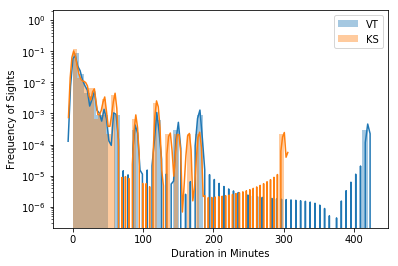

In [91]:
ufo_df_vt.Duration_sec=ufo_df_vt.Duration_sec.astype(float)
ufo_df_ks.Duration_sec=ufo_df_ks.Duration_sec.astype(float)
fig = plt.figure(figsize=(6,4))
sns.distplot(ufo_df_vt[ufo_df_vt.Duration_sec<500]['Duration_sec'], bins=50, label='VT')
sns.distplot(ufo_df_ks[ufo_df_ks.Duration_sec<500]['Duration_sec'], bins=50, label='KS')
plt.semilogy(True)
plt.ylabel('Frequency of Sights')
plt.xlabel('Duration in Minutes')
plt.legend()

In [92]:
# ufo_df.Shape.value_counts()

#### Doing a bootstrap sampling on the duration for Vermont and Kansas. 

In [93]:
vt_means = []
for i in range(1000):
    x_vt = np.random.choice(ufo_df_vt['Duration_sec'],size=500)
    vt_means.append(x_vt.mean())

In [155]:
ks_means = []
for i in range(1000):
    x_ks = np.random.choice(ufo_df_ks['Duration_sec'],size=500)
    ks_means.append(x_ks.mean())

In [156]:
# ufo_df_ks.head()

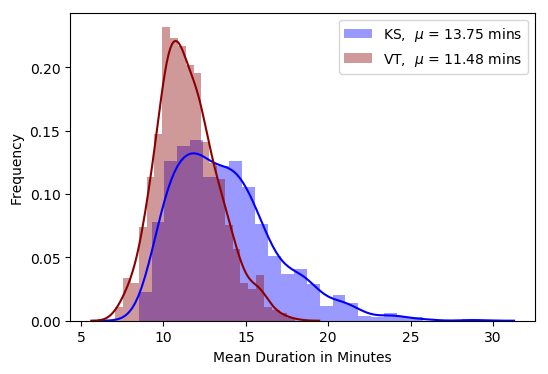

In [163]:
plt.style.use('default')
fig = plt.figure(figsize=(6,4))
ks_label = r'KS,  $\mu$ = {0:1.2f} mins'.format(np.array(ks_means).mean())
vt_label = r'VT,  $\mu$ = {0:1.2f} mins'.format(np.array(vt_means).mean())
sns.distplot(ks_means, color='blue', label=ks_label)
sns.distplot(vt_means, color='darkred', label=vt_label)
plt.ylabel('Frequency')
plt.xlabel('Mean Duration in Minutes')
plt.legend()
plt.savefig('Figures/state.png')

In [98]:
ttest_ind(ks_means,
          vt_means ,
          equal_var=False)

Ttest_indResult(statistic=19.24395125257685, pvalue=9.80453782160675e-75)

## From the p value we conclude that in Kansas the sightings last longer, but you will get more of them in Vermont. 

#### What shape would you expect to see more often?

In [106]:
ufo_df.Shape.value_counts().head(3)

Light       18609
Circle       9353
Triangle     8687
Name: Shape, dtype: int64

#### ANOVA: Do all shapes last the same amount of time? 

In [107]:
formula = 'Duration_sec ~ C(Shape)'
lm = ols(formula, ufo_df).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

               df        sum_sq       mean_sq          F        PR(>F)
C(Shape)     42.0  1.237039e+06  29453.313505  10.746247  8.405330e-70
Residual  87706.0  2.403846e+08   2740.799913        NaN           NaN


## No, not all shapes last the same time based on our P value. 

#### Looping through and filtering all the shapes' durations.

In [108]:
circle_means = []
for i in range(1000):
    x_circle = np.random.choice(ufo_df[ufo_df.Shape=='Circle']['Duration_sec'],size=500)
    circle_means.append(x_circle.mean())

In [109]:
triangle_means = []
for i in range(1000):
    x_triangle = np.random.choice(ufo_df[ufo_df.Shape=='Triangle']['Duration_sec'],size=500)
    triangle_means.append(x_triangle.mean())
    

In [110]:
light_means = []
for i in range(1000):
    x_light = np.random.choice(ufo_df[ufo_df.Shape=='Light']['Duration_sec'],size=500)
    light_means.append(x_light.mean())
    

#### Looking at the scaled histogram of the bootstrapped resampled distribution of the duration of shapes.

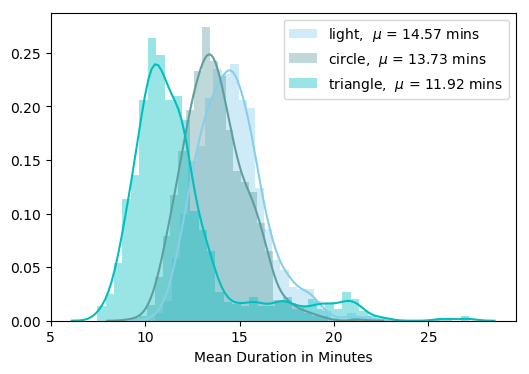

In [164]:
fig = plt.figure(figsize=(6,4))
clabel = r'circle,  $\mu$ = {0:1.2f} mins'.format(np.array(circle_means).mean())
tlabel = r'triangle,  $\mu$ = {0:1.2f} mins'.format(np.array(triangle_means).mean())
llabel = r'light,  $\mu$ = {0:1.2f} mins'.format(np.array(light_means).mean())
sns.distplot(light_means, label=llabel, color='skyblue')
sns.distplot(circle_means, label=clabel, color='cadetblue')
sns.distplot(triangle_means, label=tlabel, color='c')
plt.xlabel('Mean Duration in Minutes')
plt.legend()
plt.savefig('Figures/shape.png')

#### Three t-tests of the top most common shapes with their pairs. 

In [127]:
ttest_ind(circle_means,triangle_means,equal_var=False)

Ttest_indResult(statistic=16.92685821906091, pvalue=3.642763310184996e-59)

In [128]:
ttest_ind(circle_means,light_means,equal_var=False)

Ttest_indResult(statistic=-11.031442196589794, pvalue=1.6588668579129973e-27)

In [129]:
ttest_ind(triangle_means,light_means,equal_var=False)

Ttest_indResult(statistic=-24.41490196559307, pvalue=1.8593879692641267e-112)

## The null hypothesis was that people see them the same amount of time. If you see a light in the sky it will last 1 minute longer than a circle. Circle lasts 2 minutes longer than triangle. A light lasts almost 3 minutes longer than a triangle. 
